In [1]:
import torch
import cv2
import numpy as np
from netcal.metrics import ECE
from cnn import big_daddy
from laplace import Laplace
from load_data_cnn import get_data, get_dataloaders
import train_cnn
import utils
import argparse
from torchvision import models, transforms
from torch.nn import functional as F
from torch import topk
from PIL import Image
from torch.autograd import Variable
import torch.nn.functional as F
from matplotlib import pyplot as plt

In [2]:
#get the name of class from the label
def num_to_class(n):
    classes ={
        1 : 'ELBOW',
        2 : 'FINGER',
        3 : 'FOREARM',
        4 : 'HAND',
        5 : 'HUMERUS',
        6 : 'SHOULDER',
        7 : 'WRIST'
    }
    
    return classes[n]

# define the transforms, resize => tensor => normalize
from torchvision import transforms

transforms = transforms.Compose([
            transforms.Resize((256,256)),#224 ran out of mem
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
            
    ])

In [3]:
# https://github.com/zhoubolei/CAM/blob/master/pytorch_CAM.py
def returnCAM(feature_conv, weight_softmax, class_idx):
    # generate the class activation maps upsample to 256x256
    size_upsample = (256,256)
    bz, nc, h, w = feature_conv.shape
    output_cam = []
    for idx in class_idx:
        #take output images from the last convolutional layer(feature_conv), multiply them by their assigned weights 
        #(different weights for each class-- softmax)
        cam = weight_softmax[idx] * feature_conv.reshape((nc, h*w))[0]
        
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam

def prepare_cam_todisp(cam, width, height, orig_image, class_idx, all_classes, save_name):

    i=0

    heatmap = cv2.applyColorMap(cv2.resize(cam,(width, height)), cv2.COLORMAP_JET)
    result = heatmap * 0.3 + orig_image * 0.5
    # put class label text on the result
    cv2.putText(result, num_to_class(all_classes[class_idx[i]]), (20, 40), 
                cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 255, 0), 2)
        
    return result/255


def prepare_avg_cam_todisp(cams, width, height, orig_image, class_idx, all_classes, save_name):

    i=0
    
    #sum up all the heatmaps
    #i need to find a way to make this thing here work
    heatmaps = []
    union_cam=np.mean(np.stack(cams), axis=0).astype(np.uint8)
   
    final_heatmap = np.array(cv2.applyColorMap(cv2.resize(union_cam,(width, height)), cv2.COLORMAP_JET))
    result = final_heatmap * 0.3 + orig_image * 0.5
    # put class label text on the result
    cv2.putText(result, num_to_class(all_classes[class_idx[i]]), (20, 40), 
                cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 255, 0), 2)
        
    return result/255

def prepare_intersection_cam_todisp(cams, width, height, orig_image, class_idx, all_classes, save_name):

    i=0
    
    #sum up all the heatmaps
    #i need to find a way to make this thing here work
    heatmaps = []
    
    #we take the min for the union (instead of the max) because red is smaller compared to blue in RGB
    #Therefore taking the minimum always give us the most "active" pixel
    union_cam=np.max(np.stack(cams), axis=0).astype(np.uint8)
  
    final_heatmap = np.array(cv2.applyColorMap(cv2.resize(union_cam,(width, height)), cv2.COLORMAP_JET))
    result = final_heatmap * 0.3 + orig_image * 0.5
    # put class label text on the result
    cv2.putText(result, num_to_class(all_classes[class_idx[i]]), (20, 40), 
                cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 255, 0), 2)
        
    return result/255

def prepare_union_cam_todisp(cams, width, height, orig_image, class_idx, all_classes, save_name):

    i=0
    
    #sum up all the heatmaps
    #i need to find a way to make this thing here work
    heatmaps = []
    
    #we take the min for the union (instead of the max) because red is smaller compared to blue in RGB
    #Therefore taking the minimum always give us the most "active" pixel
    union_cam=np.min(np.stack(cams), axis=0).astype(np.uint8)
  
    final_heatmap = np.array(cv2.applyColorMap(cv2.resize(union_cam,(width, height)), cv2.COLORMAP_JET))
    result = final_heatmap * 0.3 + orig_image * 0.5
    # put class label text on the result
    cv2.putText(result, num_to_class(all_classes[class_idx[i]]), (20, 40), 
                cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 255, 0), 2)
        
    return result/255


In [52]:
def return_CAMS(image_names,model):
    '''
    INPUTS: image_names -> array containing the name of the images you want to use (N.B. only 1 layered images.)
                            WORKS WITH 1 IMAGE AT A TIME RIGHT NOW
            model -> model you want to use (N.B. run .eval before passing or weights change!)
            
    RETURNS: CAMS -> the Class Activation Map of the most porbable class for the given image+model
    '''
    #for each image do stuff
    for img_name in image_names:
        
        #open image and original image
        orig_image = cv2.imread(img_name)

        image = Image.open(img_name) 
        height, width = np.array(image).shape
        
        features_blobs = []
        def hook_feature(module, input, output):
            features_blobs.append(output.data.cpu().numpy())
        
        #register an hook that saves 'image' passed by the last convolutional layer
        model._modules.get('conv').register_forward_hook(hook_feature)
        
        params = list(model.parameters())
        #get weights of the sofmax after the convolutional 
        weight_softmax = np.squeeze(params[-3].data.numpy())
        
         # apply the image transforms to tensors
        image_tensor = transforms(image)
        # add batch dimension
        image_tensor = image_tensor.unsqueeze(0)
        # forward pass through model
        outputs = model(image_tensor)
        # get the softmax probabilities
        probs = F.softmax(outputs).data.squeeze()
        # get the class indices of top k probabilities
        class_idx = topk(probs, 1)[1].int()
        #print( topk(probs, 3))
        
        # generate class activation mapping for the top1 prediction
        CAMs = returnCAM(features_blobs[0], weight_softmax, class_idx)
        # file name to save the resulting CAM image with
        save_name = f"prova"
        
        # show and save the results
        all_classes = [1,2,3,4,5,6,7]

        heatmap_cam = prepare_cam_todisp(CAMs[0], width, height, np.array(orig_image), class_idx, all_classes, save_name)

        return CAMs[0],class_idx

In [62]:
IMAGE = 'image1_rotated.png'
NUM_NETWORKS = 10#choosing 10 still the most predicted is elbow

PICK_NETS = [2,3,4,6,8]

In [63]:
# #### Build model
model = big_daddy(in_channels=1, n_cats=7)

In [64]:
##define model and load a pretrained model
cams,class_idx = [],[]
for num in PICK_NETS:
    model.load_state_dict(torch.load('./models/model_'+str(num)+'.pth',map_location=torch.device('cpu')))

    #stop re-training and only pass images through networks
    model.eval()
    tmp_cam,class_idx_tmp = return_CAMS([IMAGE],model)
    cams.append(tmp_cam)
    class_idx.append(class_idx_tmp)

C:\Users\aless\AppData\Local\Temp\ipykernel_4872\1136428221.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(outputs).data.squeeze()


Display the CAMs obtained by the **N** different pretrained networks

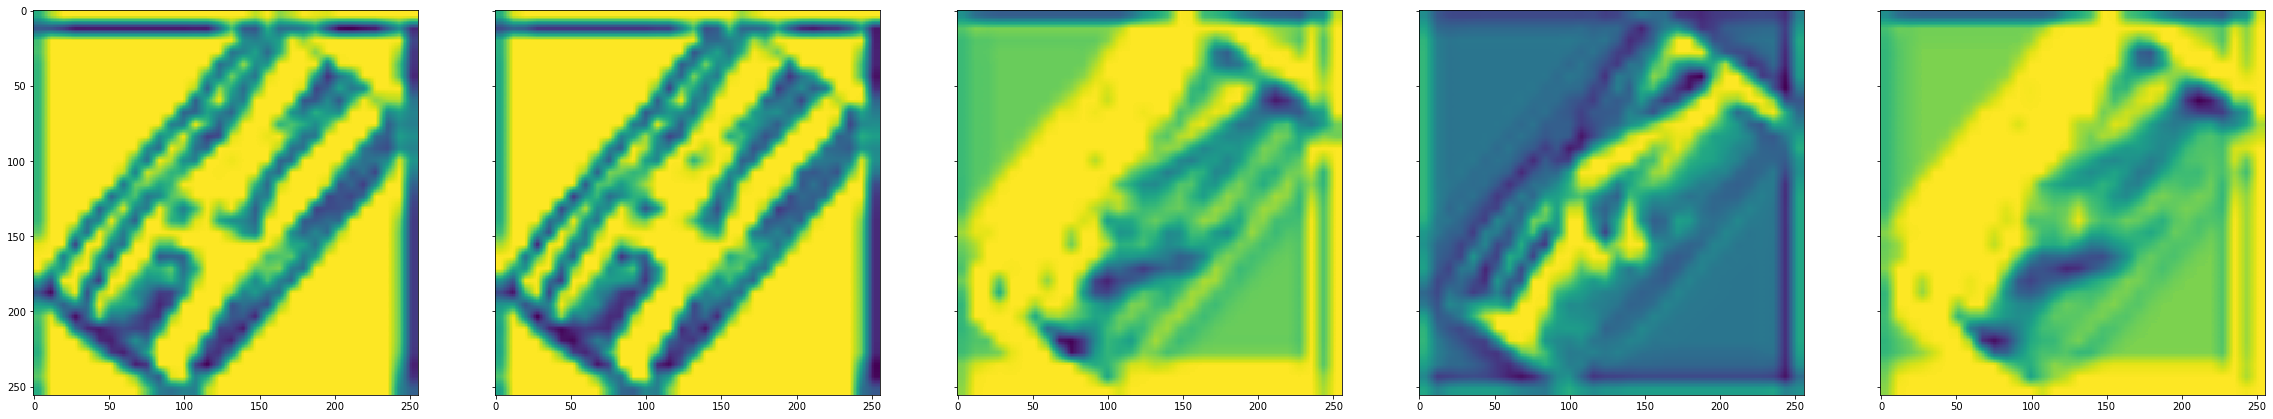

In [65]:
fig, ax = plt.subplots(1,len(cams),sharey='row', figsize=(40,20)) # nrows, ncols you need 5 columns
for i in range(len(cams)):

    ax[i].imshow(cams[i], interpolation='nearest')

In [66]:
from matplotlib.colors import LinearSegmentedColormap

orig_image = cv2.imread(IMAGE)
image = Image.open(IMAGE) 
height, width = np.array(image).shape
#class_idx=[0]
all_classes=[1,2,3,4,5,6,7]
save_name=''



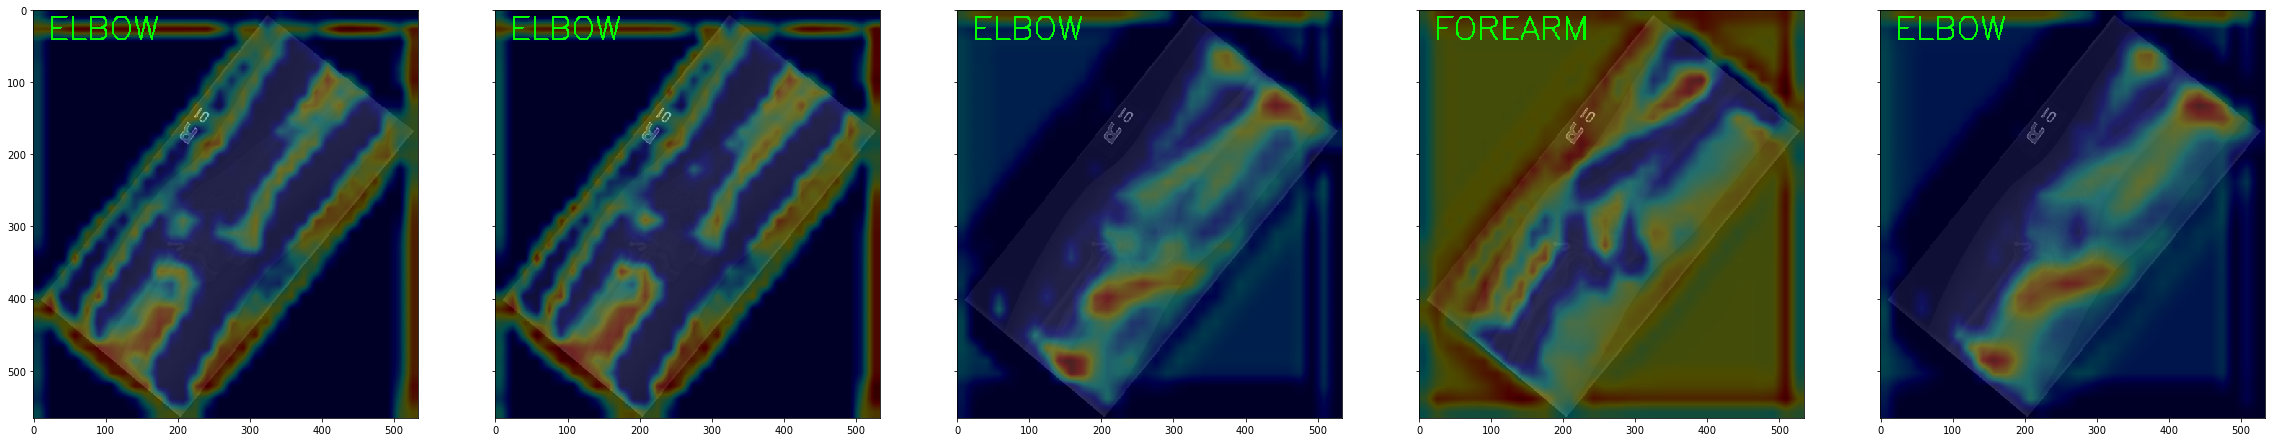

In [67]:
fig, ax = plt.subplots(1,len(cams),sharey='row', figsize=(40,15)) # nrows, ncols you need 5 columns
for i in range(len(cams)):

    ax[i].imshow( prepare_cam_todisp(cams[i], width, height, np.array(orig_image), class_idx[i], all_classes, save_name), interpolation='nearest')

Average the CAMs and display the heatmap

In [68]:
from collections import Counter

#find most predicted class index
Counters_found = Counter([x[0].item() for x in class_idx])
most_occur = Counters_found.most_common()
#print(int(most_occur[0][0]))
print(most_occur)

[(0, 4), (2, 1)]


In [69]:
class_idx = torch.tensor([most_occur[0][0]])
class_idx

tensor([0])

Text(0.5, 1.0, 'Union of CAMs')

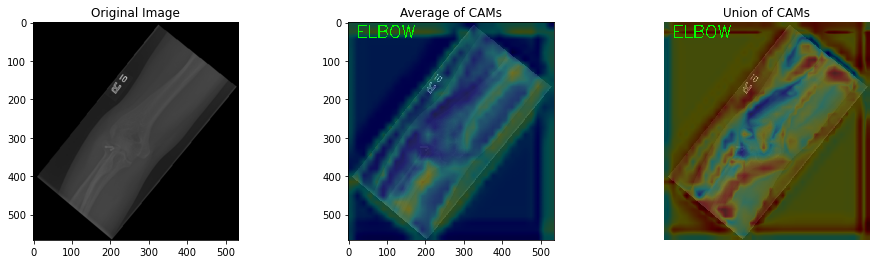

In [79]:

        
fig, ax = plt.subplots(1,3,figsize=(16,4))
plt.axis('off')

#average the cams and turn them into an heatmap
heatmap_cam = prepare_avg_cam_todisp(cams, width, height, np.array(orig_image), class_idx, all_classes, save_name)
ax[0].imshow(orig_image)
ax[0].set_title("Original Image")

ax[1].imshow(heatmap_cam,interpolation = 'nearest',
                 cmap='jet')
ax[1].set_title("Average of CAMs")


plt.axis('off')
#Union
heatmap_cam = prepare_union_cam_todisp(cams, width, height, np.array(orig_image), class_idx, all_classes, save_name)
ax[2].imshow(heatmap_cam,interpolation = 'nearest',
                 cmap='jet')
ax[2].set_title("Union of CAMs")





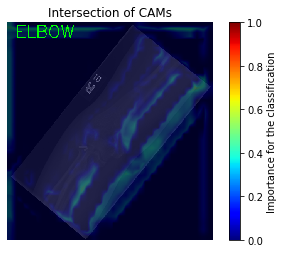

In [80]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
plt.axis('off')
#Intersection
#average the cams and turn them into an heatmap
heatmap_cam = prepare_intersection_cam_todisp(cams, width, height, np.array(orig_image), class_idx, all_classes, save_name)
ax.imshow(heatmap_cam,interpolation = 'nearest',
                 cmap='jet') 
ax.set_title("Intersection of CAMs")
# make bar
bar = plt.colorbar(ax.imshow(heatmap_cam,interpolation = 'nearest',
                 cmap='jet') )
bar.set_label('Importance for the classification', color='black')


plt.show()